This code fits projection matrix (A) from behavioral to neural state, and kernels (ks, kd) where kd is modulated by this projection. 

Steps: (1) load the behavioral state and neural data, (2) do a minor preprocessing of the neural data, (3) fit a fixed A, ks, and kd (4) fix the ks and kd, and fit A(t) using random walk prior, (5) fit A(t), ks, kd jointly with a random walk prior

In [1]:
# load fitted behavior

import pickle
import numpy as np

f = open('all_animals_beh_05log10_grid.pckl', 'rb')
all_animals, sigmas, E, sigma_opt, w_opt, all_data = pickle.load(f)
f.close()

In [2]:
# load neural data

from helpers import load_neur_data_alltiles

animal = 15100
dff_flat_alltiles = load_neur_data_alltiles( animal )

In [3]:
# Get behavioral state (w_beh), neural observations (z), input matrix (X) 

M = 4 # dimensions of behavioral state
w_beh = np.reshape( w_opt[all_animals.index(animal)], (-1,M) ) # behavioral state vector in time
N,_ = w_beh.shape # number of trials

T = 25 # number of time bins
tile_id = 151 # corresponds to animal 15100
z = dff_flat_alltiles[tile_id,:] # neural response across all timebins and trials; timebin index changes fast, trial-slow


K = 1 # one neural kernel (movement)
krnsz=[0, 17] # size of the kernel in time bins [anticausal, causal]
krnlen=sum(krnsz)+1

from helpers import load_neur_data
from model import makeX_new_v2, prepInp_new_v2

# prepare matrix X using "wheel event" input xwhl 
any_tile_id = 10
_,_,_,xwhl = load_neur_data(animal, any_tile_id )
inp_padded = prepInp_new_v2(xwhl,N,T,krnsz,K)

X = makeX_new_v2(inp_padded,T,krnlen,N,K) # size of X is (N*T,krnlen,K)

#### Fitting

##### 1. Fixed projection weights (A) and kernels (k). Maximum likelihood estimate of both. 

In [8]:
from model import likelihoodAk, gradientAk
from scipy.optimize import minimize, Bounds
s = 0.1 # noise variance, estimated in a separate script

m_lAk = lambda params: -likelihoodAk(z,params,w_beh,X,s, Aisdyn=False)
m_gAk = lambda params: -gradientAk(z,params,w_beh,X,T,s, Aisdyn=False) 

Ak0 = np.random.randn(M * K + 2 * krnlen * K, 1)
lower_bound = -10*np.ones((Ak0.shape)) 
lower_bound[-10 - krnlen] = 0 # forces positive dynamic kernel ( otherwise the sign is ambiguous )
bds = Bounds(lower_bound, 10*np.ones((Ak0.shape)))
out = minimize(m_lAk, Ak0, jac=m_gAk, bounds=bds, options={'disp': True} )

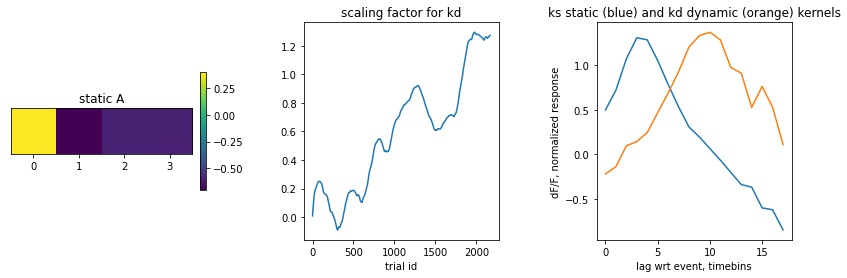

In [9]:
import matplotlib.pyplot as plt

plt.figure( figsize=(14,4) )

plt.subplot(1,3,1)
A_fit = out.x[:M*K]
im=plt.imshow( A_fit[None,:])
plt.title('static A')
plt.yticks([])
plt.colorbar(im,fraction=0.03, pad=0.04)

plt.subplot(1,3,2)
Aw = w_beh @ A_fit
plt.plot(Aw)
plt.title('scaling factor for kd')
plt.xlabel('trial id')

plt.subplot(1,3,3)
ks = out.x[M*K+krnlen:][::-1]
kd = out.x[M*K:M*K+krnlen][::-1]
plt.plot(ks)
plt.plot(kd)
plt.title('ks static (blue) and kd dynamic (orange) kernels')
plt.xlabel('lag wrt event, timebins')
plt.ylabel('dF/F, normalized response')

plt.subplots_adjust(wspace=0.5)

##### 2. Fix the kernels (ks, kd) and fit the dynamic projection A(t)

In [10]:
from model import likelihoodA, gradientA, calcC_useSparse_highInit, calcLogNpri, calcGradPrior
from scipy.optimize import minimize, Bounds

s = 0.1
sigmaA = 0.003 # variance of random walk step
sigmaInit = 0.03 # variance of first step
krn_concat = np.concatenate((kd,ks))

Cm1A, logdetCm1A = calcC_useSparse_highInit(N,M*K,sigmaA,sigmaInit) # inverse of prior covariance of A
priAdyn = lambda params: calcLogNpri(params, Cm1A, logdetCm1A) # log prior given vectorized A (params)
gr_A_pri = lambda params: np.asarray( calcGradPrior(Cm1A,params) ).ravel() # gradient of log prior given vectorized A

m_lAk = lambda params: -likelihoodA(z,params, w_beh, X, s, krn_concat[:,None], Aisdyn=True) - priAdyn(params)
m_gAk = lambda params: -gradientA(z,params, w_beh, X, T, s, krn_concat[:,None], Aisdyn=True) - gr_A_pri(params)


Ak0 = np.random.randn(N * M * K , 1)
bds = Bounds(-10*np.ones((Ak0.shape)), 10*np.ones((Ak0.shape)))
out_A = minimize(m_lAk, Ak0, jac=m_gAk, bounds=bds, options={'disp': True} )

Text(0, 0.5, 'Aw')

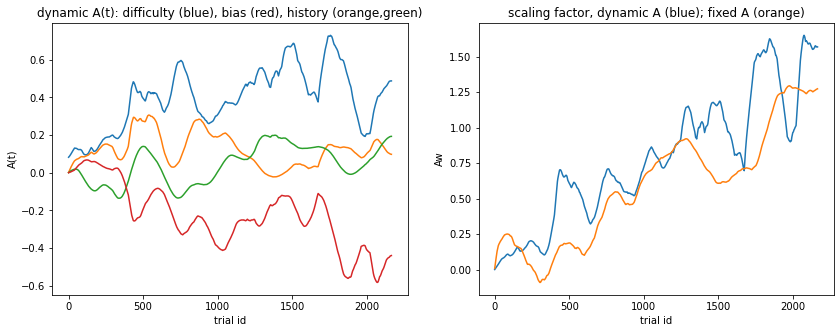

In [11]:
plt.figure( figsize=(14,5))

plt.subplot(1,2,1)
A_fit = np.reshape(out_A.x, (-1,M))
plt.plot( A_fit )
plt.title('dynamic A(t): difficulty (blue), bias (red), history (orange,green)')
plt.xlabel('trial id')
plt.ylabel('A(t)')

plt.subplot(1,2,2)
Atw = np.einsum('ij,ij->i',A_fit,w_beh)
plt.plot(Atw)
plt.plot(Aw)
plt.title('scaling factor, dynamic A (blue); fixed A (orange)')
plt.xlabel('trial id')
plt.ylabel('Aw')

##### 3. Fit A(t) and ks, kd jointly, with random walk priors on all

In [12]:
from model import logdet

std_dkrn = 1.0#0.2
std_dkrn_init = 1.0#0.2

Cm1k_block, _ = calcC_useSparse_highInit(krnlen, K, std_dkrn, std_dkrn_init)
Cm1k = np.block([
    [Cm1k_block, np.zeros(Cm1k_block.shape)],
    [np.zeros(Cm1k_block.shape), Cm1k_block]
])
logdetCm1k = logdet(Cm1k)


priAdyn = lambda Atr: calcLogNpri(Atr, Cm1A, logdetCm1A)
priKern = lambda kernel: calcLogNpri( kernel, Cm1k, logdetCm1k )
gr_A_pri = lambda Atr: np.asarray( calcGradPrior(Cm1A,Atr) ).ravel()
gr_k_pri = lambda kernel: np.asarray( calcGradPrior( Cm1k, kernel) ).ravel()
grAdyn_expanded_k = lambda params: np.concatenate((gr_A_pri(params[:N*M*K]), gr_k_pri(params[N*M*K:]) ))

m_lAk = lambda params: -likelihoodAk(z,params,w_beh,X,s, Aisdyn=True) - priAdyn(params[:N*M*K]) - priKern(params[N*M*K:])
m_gAk = lambda params: -gradientAk(z,params,w_beh,X,T,s, Aisdyn=True) - grAdyn_expanded_k(params)

Ak0 = np.concatenate((out_A.x, krn_concat))
bds = Bounds(-10*np.ones((Ak0.shape)), 10*np.ones((Ak0.shape)))
out_Ak = minimize(m_lAk, Ak0, jac=m_gAk, bounds=bds) #, options={'disp': True, 'ftol':1e-9,'gtol':1e-09} )

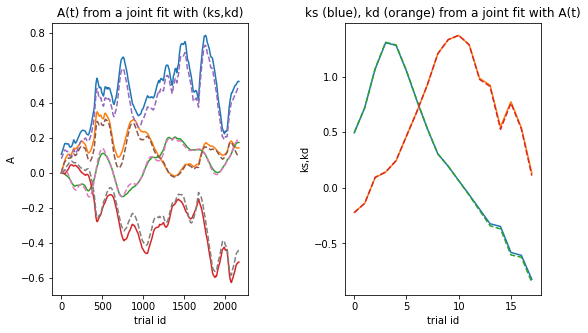

In [13]:
plt.figure( figsize=(14,5) )

plt.subplot(1,3,1)
A_Ak_fit = np.reshape( out_Ak.x[:N*M*K], (-1,M) )
plt.plot( A_Ak_fit )

plt.plot(A_fit,'--')

plt.title('A(t) from a joint fit with (ks,kd)')
plt.xlabel('trial id')
plt.ylabel('A')

plt.subplot(1,3,2)

ks_Ak_fit = out_Ak.x[N*M*K+krnlen:]
kd_Ak_fit = out_Ak.x[N*M*K:N*M*K+krnlen]
plt.plot( ks_Ak_fit  )
plt.plot( kd_Ak_fit  )

plt.plot(ks,'--')
plt.plot(kd,'--')

plt.title('ks (blue), kd (orange) from a joint fit with A(t)')
plt.xlabel('trial id')
plt.ylabel('ks,kd')

plt.subplots_adjust(wspace=0.5)